### Pre-mining data processing

Remove unnecessary attributes, rename attributes for ease of referencing

In [12]:
import pandas as pd
import math, random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Specify the input CSV file and row number to split at
input_file = 'merged_datasets.csv'
# Function to separate CSV based on row number

# Read the input CSV file
df = pd.read_csv(input_file, header="infer")

# Split the DataFrame based on the row number
df = df.drop(columns=["HUMAN PLAYER POSITION (X) metres","HUMAN PLAYER POSITION (Y) metres","INITITAL VELOCITY OF SHUTTELCOCK(m/s)","INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)","SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)","OUT_OF_COURT_SHOTS"])
df = df.rename(columns={"SHUTTLECOCK POSITIION IN AIR(X ) metres":"X","SHUTTLECOCK POSITIION IN AIR(Y) metres":"Y","SHUTTLECOCK POSITIION IN AIR(Z) metres":"Z"})

print(df.shape)
df

(91348, 4)


,SHOT_ID,X,Y,Z
0,1,4.075543,1.000000,1.662912
1,1,4.152007,1.000000,1.724866
2,1,4.228906,1.000000,1.788139
3,1,4.302100,1.000000,1.845245
4,1,4.376877,1.000000,1.904128
...,...,...,...,...
91343,658,8.061748,8.840603,6.084177
91344,658,8.088022,8.871915,6.044289
91345,658,8.111243,8.899588,6.001045
91346,658,8.138342,8.931884,5.952024


Create training and testing set

In [13]:
numShots = df["SHOT_ID"].max()
print(numShots)
trainsetSize = int(numShots*0.7)
print(trainsetSize)
testsetSize = numShots-trainsetSize
traindata = df.loc[df["SHOT_ID"]<= trainsetSize]
testdata = df.loc[df["SHOT_ID"] > trainsetSize]
print(traindata.head())
print(testdata.head())

658
460
   SHOT_ID         X    Y         Z
0        1  4.075543  1.0  1.662912
1        1  4.152007  1.0  1.724866
2        1  4.228906  1.0  1.788139
3        1  4.302100  1.0  1.845245
4        1  4.376877  1.0  1.904128
       SHOT_ID         X         Y         Z
61196      461  4.050120  1.005268  2.685985
61197      461  4.099803  1.010490  2.770552
61198      461  4.147361  1.015488  2.853052
61199      461  4.197503  1.020758  2.934503
61200      461  4.245438  1.025797  3.013947


Scale data to normalise

In [14]:
scale = MinMaxScaler()
traindata[["X","Y","Z"]] = scale.fit_transform(traindata[["X","Y","Z"]])
testdata[["X","Y","Z"]] = scale.fit_transform(testdata[["X","Y","Z"]])
print(traindata.head())
print(testdata.head())

   SHOT_ID         X    Y         Z
0        1  0.005270  0.0  0.247642
1        1  0.019367  0.0  0.257424
2        1  0.033543  0.0  0.267413
3        1  0.047036  0.0  0.276429
4        1  0.060821  0.0  0.285726
       SHOT_ID         X         Y         Z
61196      461  0.000605  0.000000  0.403795
61197      461  0.010597  0.000654  0.417263
61198      461  0.020161  0.001281  0.430403
61199      461  0.030245  0.001941  0.443376
61200      461  0.039886  0.002573  0.456029


C:\Users\Esther\AppData\Local\Temp\ipykernel_39188\3751249483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindata[["X","Y","Z"]] = scale.fit_transform(traindata[["X","Y","Z"]])
C:\Users\Esther\AppData\Local\Temp\ipykernel_39188\3751249483.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata[["X","Y","Z"]] = scale.fit_transform(testdata[["X","Y","Z"]])


prepare_data function to create attribute set (X,Y,Z) and class labels

In [30]:
# Individual data points in X, Y
def prepare_data(data, sequence_length):
    X = []
    Y = []
    for shot_id in data['SHOT_ID'].unique(): # for each shot id
        X.append(data.loc[data['SHOT_ID'] == shot_id][['X', 'Y', 'Z']].values[0:sequence_length]) # get xyz
        Y.append(data.loc[data['SHOT_ID'] == shot_id][['X', 'Y', 'Z']].values[1:sequence_length+1])
    X = np.array(X)
    X = X.reshape(-1, 3)
    Y = np.array(Y)
    Y = Y.reshape(-1, 3)
    print(X.shape, Y.shape)
    return X, Y

# Delta between consecutive data points in X, Y
def prepare_data_deltas(data, sequence_length):
    X = []
    Y = []
    for shot_id in data['SHOT_ID'].unique(): # for each shot id
        shotdata = (data.loc[data['SHOT_ID'] == shot_id][['X', 'Y', 'Z']].values) # get xyz
        X1 = shotdata[:sequence_length]
        X2 = shotdata[1:sequence_length+1] 
        X.append(X2 - X1)
        Y1 = shotdata[1:sequence_length+1]
        Y2 = shotdata[2:sequence_length+2]
        Y.append(Y2 - Y1)
    X = np.array(X, dtype=object)
    X = np.concatenate(X)
    X = X.reshape(-1, 3)
    Y = np.array(Y, dtype=object)
    Y = np.concatenate(Y)
    Y = Y.reshape(-1, 3)
    # final shape should be n rows of 3
    print(X.shape, Y.shape)
    return X, Y

Create training/testing set containing the 1st 15 XYZ values for each shot, and class labels containing the XYZ values of the 2nd to 16th XYZ of each shot

In [31]:
sequence_length =15
X_train, Y_train = prepare_data(traindata, sequence_length)

X_test, Y_test = prepare_data(testdata, sequence_length)


(6900, 3) (6900, 3)
(2970, 3) (2970, 3)


Create training/testing set of deltas

In [32]:
sequence_length = 15
X_delta_train, Y_delta_train = prepare_data_deltas(traindata, sequence_length)

X_delta_test, Y_delta_test = prepare_data_deltas(testdata, sequence_length)

(6900, 3) (6900, 3)
(2970, 3) (2970, 3)


Train Gaussian Regressor 1 on 15 raw points (prepare_data)

In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import joblib

kernel = RBF()
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.X_train_ = X_train
gpr.y_train_ = Y_train
gpr.n_features_in_ = 3
gpr.fit(X_train, Y_train)
# joblib.dump(gpr, 'gaussian_process_model.pkl')


c:\Users\Esther\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=RBF(length_scale=1))

GPR prediction, RMSE and plot

Mean Squared Error: 0.188428184805323
Root Mean Squared Error: 0.4340831542519509


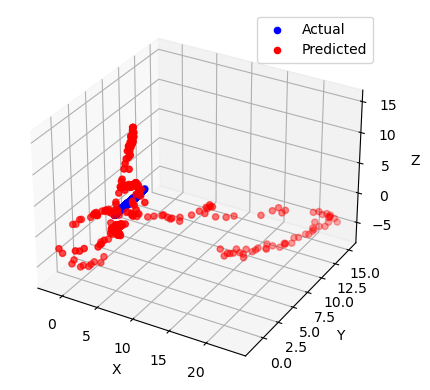

In [27]:
# Convert predictions back to original scale for plotting
from sklearn.metrics import mean_squared_error

Y_pred = gpr.predict(X_test)

Y_test_inv = scale.inverse_transform(Y_test)
Y_pred_inv = scale.inverse_transform(Y_pred)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

# 3D Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(Y_test_inv[:,0], Y_test_inv[:,1], Y_test_inv[:,2], color='b', label='Actual')
ax.scatter(Y_pred_inv[:,0], Y_pred_inv[:,1], Y_pred_inv[:,2], color='r',label='Predicted')
plt.legend()
plt.show()

GPR_delta model, trained on differences between adjacent points

In [33]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import joblib

kernel = RBF()
gpr_delta = GaussianProcessRegressor(kernel=kernel)
gpr_delta.X_train_ = X_delta_train
gpr_delta.y_train_ = Y_delta_train
gpr_delta.n_features_in_ = 3
gpr_delta.fit(X_delta_train, Y_delta_train)

c:\Users\Esther\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=RBF(length_scale=1))

GPR prediction, RMSE and plot

Mean Squared Error: 0.12942557522113565
Root Mean Squared Error: 0.3597576617962926


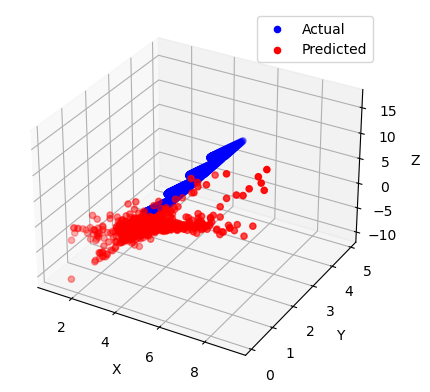

In [38]:
# Convert predictions back to original scale for plotting
from sklearn.metrics import mean_squared_error

Y_pred = gpr_delta.predict(X_delta_test)

Y_test_inv = scale.inverse_transform(Y_test)
Y_pred_inv = scale.inverse_transform(Y_pred)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

# 3D Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(Y_test_inv[:,0], Y_test_inv[:,1], Y_test_inv[:,2], color='b', label='Actual')
ax.scatter(Y_pred_inv[:,0], Y_pred_inv[:,1], Y_pred_inv[:,2], color='r',label='Predicted')
plt.legend()
plt.show()

In [22]:
gpr.score(X_train, Y_train)
# joblib.dump(gpr, 'gaussian_process_model.pkl') # OSError: [Errno 28] No space left on device

0.9999999838022159

Train Gaussian Regressor 2 on delta between points (prepare_data_delta)

GPR1: Given 1 point, predict the next.

In [ ]:
def predict_next_point(currentPoint):
    newPoint = gpr.predict(currentPoint)
    return newPoint


Train with delta between points. (n - n+1) to predict n+2

Train Random Forest Model

In [13]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense,Dropout

# Define the Random Forest regression model with an appropriate number of estimators
n_estimators = 100  # Adjust the number of estimators based on your data and requirements

model = RandomForestClassifier()

# Fit the Random Forest model to the data
model.fit(X_train, Y_train)

# Predict the trajectory using the trained Random Forest model
predicted_trajectory = model.predict(X_test)

# Incorporate feedback by including the new observation in the training data
new_observation = np.array([X_test[0, 0], X_test[0, 1], X_test[0, 2], predicted_trajectory[0]])
X = np.vstack((X_train, X_test))
y = np.append(Y_train, new_observation[3])

# Update the Random Forest model with the new data
model.fit(X, y)

# Generate a new test sample (replace with your desired input features)
new_sample = np.array([[2, 12, 60]])  # Example: time = 2, initial speed = 12, launch angle = 60

# Predict the trajectory using the updated Random Forest model
predicted_trajectory = model.predict(new_sample)

# Print the predicted trajectory
print("Predicted trajectory with feedback:")
print(predicted_trajectory)


ValueError: Found array with dim 3. Estimator expected <= 2.

Separate data into timeseries of X, Y and Z for each shot, using index as the indication of time

Also create a set of expected X and Y values for when shuttlecock height is near the robot's racket height

In [61]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
print(X_train.shape, Y_train.shape)
# X_train = X_train.reshape((X_train.shape[0], -1))
# Y_train = Y_train.reshape((Y_train.shape[0], -1))
n_samples, sequence_length, n_features = X_train.shape
X_train_2d = X_train.reshape(n_samples, sequence_length * n_features)
Y_train_2d = Y_train.reshape(n_samples, n_features)

kernel = RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X_train_2d, Y_train_2d)
predictedCord = gpr.predict(X_train_2d[-1].reshape(1, -1))
print(predictedCord)

(54296, 15, 3) (54296, 3)


MemoryError: Unable to allocate 11.0 GiB for an array with shape (1474000660,) and data type float64

In [26]:
# Separate each shot
# For each shot, add to the x y z array, using index starting from 0 as time attribute

# Group the DataFrame by shotID and create arrays of time, x, y and z for each group
df_listed = df.groupby('SHOT_ID').apply(lambda g: [np.arange(len(g)), g['X'].values.tolist(), g['Y'].values.tolist(), g['Z'].values.tolist()])

# Convert the grouped data into array of objects
shot_data_array = np.array([{'time': data[0], 'X': data[1], 'Y': data[2], 'Z': data[3]} for data in df_listed])

# Get the x and y value corresponding to the point where Z is closest to the height of the racket's top quarter (>=1.13m)
threshold = 1.13
min_starting_z = 1.6 # assuming all shots, even testing ones, start at a minimum height of 1.6m
x_values = []
y_values = []
for data in shot_data_array:
    z_values = np.array(data['Z'])
    indices = np.where((z_values > threshold) & (z_values < min_starting_z))[0]
    if len(indices) > 0:
        closest_set = indices[np.abs(z_values[indices] - threshold).argmin()]
        x_values.append(data['X'][closest_set])
        y_values.append(data['Y'][closest_set])
        
    else: # TODO remove this, data should have values between 1.13 and 1.6
        # middle of the court, no need to receive shuttlecock
        x_values.append(2.59) 
        y_values.append(10.86) 
final_xy_array = np.array([{'X': x_values[i], 'Y': y_values[i]} for i in range(len(x_values))])
print(len(shot_data_array)) # should match max SHOT_ID, 658
print(shot_data_array[0])
print(final_xy_array[0])

658
{'time': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121]), 'X': [4.075542591, 4.152006773, 4.228906143, 4.302099746, 4.376877391, 4.449410593, 4.522097914, 4.595428732, 4.668033747, 4.739584146, 4.809587653, 4.881531438, 4.95120765, 5.021340663, 5.089209194, 5.158574787, 5.226182675, 5.294275267, 5.359640471, 5.425936189, 5.491976752, 5.555443927, 5.619701891, 5

Split data into training and testing sets

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_2, Y, test_size=0.3, random_state=12)
trainingRatio = 0.7
numShots = badminton1["SHOT_ID"].max() + badminton2["SHOT_ID"].max()
print("Total number of shots: " + str(numShots))
trainsetSize = int(numShots*trainingRatio)
trainsetSize_bdm1 = int(badminton1["SHOT_ID"].max()*trainingRatio)
trainsetSize_bdm2 = int(badminton2["SHOT_ID"].max()*trainingRatio)
print("Total training set size (# shots): " + str(trainsetSize))
print("Split between 1.6m and 2.6m shots: " + str(trainsetSize_bdm1) +" of " + str(badminton1["SHOT_ID"].max()) + ", " +str(trainsetSize_bdm2) + " of " + str(badminton2["SHOT_ID"].max()))
testsetSize = numShots-trainsetSize
traindata = badminton1.loc[badminton1["SHOT_ID"]<= trainsetSize_bdm1]
badminton2.loc[badminton2['SHOT_ID'] > 0, 'SHOT_ID'] += trainsetSize_bdm1 # to make the SHOT_IDs continuous from badminton1's
traindata = traindata.append(badminton2.loc[badminton2["SHOT_ID"]<= (trainsetSize_bdm1+trainsetSize_bdm2)])


testdata = badminton1.loc[badminton1["SHOT_ID"] > trainsetSize_bdm1]
testdata.loc[testdata['SHOT_ID'] > trainsetSize_bdm1, 'SHOT_ID'] -= trainsetSize_bdm1 # to make the SHOT_IDs start from 1
badminton2.loc[badminton2['SHOT_ID'] > 0, 'SHOT_ID'] += (-trainsetSize_bdm1 + badminton1['SHOT_ID'].max()) # to make the SHOT_IDs start from the final SHOT_ID of badminton1
testdata = testdata.append(badminton2.loc[badminton2["SHOT_ID"] > (trainsetSize_bdm2+badminton1['SHOT_ID'].max())])
testdata.loc[testdata['SHOT_ID'] > badminton1['SHOT_ID'].max(), 'SHOT_ID'] -= trainsetSize

print(traindata)
print(testdata)

NameError: name 'X_pca_2' is not defined

### Data Mining
#### Step 1. Decide between individual prediction of x, y and z values, or predict x, y and z together
##### 1.1. Are x, y and z related? (Raw values)

In [ ]:
# Analyse the correlation between x and y values for shot 1
%matplotlib inline

#get cosine similarity between x and y values
def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))
def length(v):
    length = math.sqrt(dotproduct(v, v))
    if(length==0):
        return 0.0000000000000001
    return length

def angle(v1, v2):
    return dotproduct(v1, v2) / (length(v1) * length(v2))

shots = []
i=0
while i <5:
    #generate random value within a range
    shots.append(random.randint(1, len(badminton1.index)))
    i+=1

for i in shots:
    shot = badminton1[badminton1['SHOT_ID']== i]
    print('Shot %d Cosine Similarity' % i)
    print('X and Y: ' + str(angle(shot['X'], shot['Y'])))
    print('X and Z: ' + str(angle(shot['X'], shot['Z'])))
    print('Y and Z: ' + str(angle(shot['Y'], shot['Z'])))
    # print('Shot angle: ' + str(statistics.mean(shot['SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)'])))
    # print

#Observation: Low cosine similarities between raw X, Y and Z values
# This suggests that with the raw values of X, Y and Z, 

Shot 31940 Cosine Similarity
X and Y: 0.0
X and Z: 0.0
Y and Z: 0.0
Shot 8818 Cosine Similarity
X and Y: 0.0
X and Z: 0.0
Y and Z: 0.0
Shot 2690 Cosine Similarity
X and Y: 0.0
X and Z: 0.0
Y and Z: 0.0
Shot 20506 Cosine Similarity
X and Y: 0.0
X and Z: 0.0
Y and Z: 0.0
Shot 28212 Cosine Similarity
X and Y: 0.0
X and Z: 0.0
Y and Z: 0.0


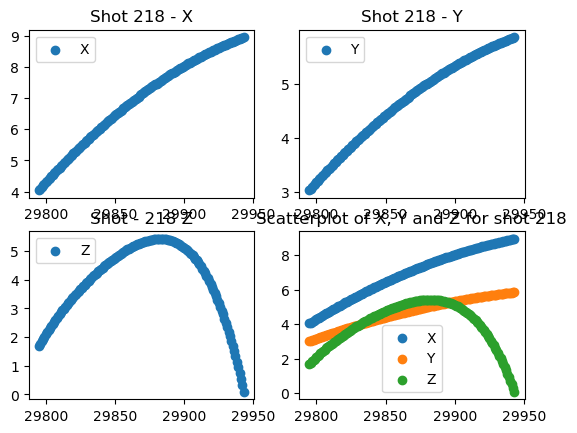

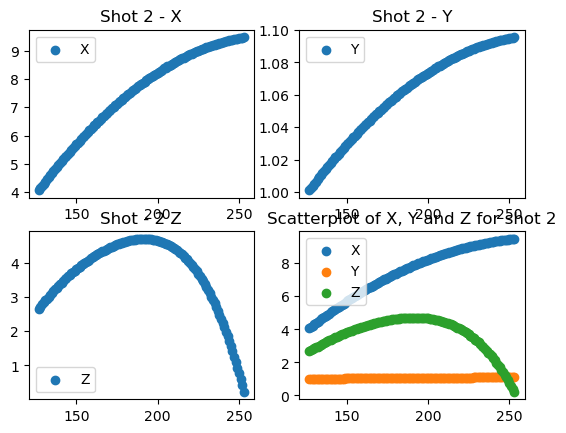

In [ ]:
# Visualise the lack of correlation or non-linear relationship between X, Y and Z values
fig, axs = plt.subplots(2,2)
i = random.randint(1, max(badminton1['SHOT_ID']))
shot = badminton1[badminton1['SHOT_ID'] == i]
shotx = shot['X']
shoty = shot['Y']
shotz = shot['Z']
axs[0][0].scatter(shot.index, shotx, label='X')
axs[0][1].scatter(shot.index, shoty, label='Y')
axs[1][0].scatter(shot.index, shotz, label='Z')

# Set legends and titles for each plot
axs[0][0].legend()
axs[0][0].set_title('Shot %d - X' % i)

axs[0][1].legend()
axs[0][1].set_title('Shot %d - Y'% i)

axs[1][0].legend()
axs[1][0].set_title('Shot - %d Z'% i)

plt.scatter(shot.index,shotx, label='X')
plt.scatter(shot.index,shoty, label='Y')
plt.scatter(shot.index,shotz, label='Z')
plt.legend()
plt.title('Scatterplot of X, Y and Z for shot %d' %i)
plt.show()

# Similarly for badminton2
fig, axs = plt.subplots(2,2)
i = random.randint(1, max(badminton2['SHOT_ID']))
shot = badminton2[badminton2['SHOT_ID'] == i]
shotx = shot['X']
shoty = shot['Y']
shotz = shot['Z']
axs[0][0].scatter(shot.index, shotx, label='X')
axs[0][1].scatter(shot.index, shoty, label='Y')
axs[1][0].scatter(shot.index, shotz, label='Z')

# Set legends and titles for each plot
axs[0][0].legend()
axs[0][0].set_title('Shot %d - X' % i)

axs[0][1].legend()
axs[0][1].set_title('Shot %d - Y'% i)

axs[1][0].legend()
axs[1][0].set_title('Shot - %d Z'% i)

plt.scatter(shot.index,shotx, label='X')
plt.scatter(shot.index,shoty, label='Y')
plt.scatter(shot.index,shotz, label='Z')
plt.legend()
plt.title('Scatterplot of X, Y and Z for shot %d' %i)
plt.show()


### 1.2. Are x, y and z related? (delta)
Feature creation to explore correlation - generate the changes in x, y and z between the first n data points of each shot

In [ ]:
# Find the lowest number of points taken for the shuttlecock to reach the shot's peak
# This is to find the maximum number of points that can be used to predict the peak of the shuttlecock

grouped = traindata.groupby('SHOT_ID')
peaks = grouped['Z'].max()

peak_index = []
first_shot_index = []
points_to_peak = []
min_points_to_peak = 0
for i in range(1, len(grouped)+1): # iterate through each peak
    peak_value = peaks[i]
    peak_records = badminton1[(badminton1['SHOT_ID'] == i) & (badminton1['Z'] == peak_value)]
    peak_index.extend(peak_records.index.tolist())
    first_shot_index.extend(grouped.head(1).index.tolist())
    points_to_peak.append(peak_index[i-1] - first_shot_index[i-1])
    if i == 1:
        min_points_to_peak = points_to_peak[i-1]
    else:
        if points_to_peak[i-1] < min_points_to_peak:
            min_points_to_peak = points_to_peak[i-1]
print("Index of peak:", peak_index)
print("Points to peak:", points_to_peak)
print("Min points to peak:", min_points_to_peak)


badminton1 data (1.6m shots)
Peak Index: [65, 185, 309, 432, 553, 675, 796, 919, 1040, 1163, 1284, 1406, 1529, 1651, 1773, 1893, 2016, 2139, 2261, 2382, 2504, 2626, 2749, 2870, 2993, 3115, 3236, 3359, 3480, 3604, 3724, 3847, 3967, 4091, 4213, 4335, 4456, 4577, 4701, 4823, 4945, 5066, 5189, 5310, 5433, 5555, 5675, 5798, 5920, 6042, 6164, 6288, 6410, 6530, 6653, 6776, 6896, 7019, 7140, 7264, 7386, 7507, 7628, 7751, 7872, 7994, 8116, 8240, 8362, 8483, 8605, 8727, 8849, 8970, 9093, 9215, 9337, 9458, 9580, 9702, 9824, 9947, 10069, 10191, 10313, 10435, 10556, 10678, 10801, 10923, 11045, 11166, 11288, 11411, 11555, 11704, 11853, 12002, 12151, 12301, 12449, 12598, 12748, 12897, 13046, 13195, 13344, 13492, 13640, 13790, 13938, 14089, 14237, 14385, 14536, 14685, 14834, 14983, 15131, 15280, 15430, 15579, 15727, 15876, 16026, 16174, 16323, 16472, 16621, 16770, 16919, 17068, 17217, 17367, 17515, 17664, 17814, 17962, 18112, 18260, 18409, 18559, 18707, 18856, 19004, 19154, 19303, 19452, 19601, 19751,

Since both badminton1 and badminton2 data have shots that reach their peak after a maximum of 63 data points, we will use n <= 63 for the subsequent calculations and predictions.

Feature creation: 
Take the changes in x, y and z between each shot's first 63 data points and identify any relationship between the individual axes' changes. Correlate this with the Euclidean Distance between each point too.

Hypotheses: 
1. For each shot, Z influences the magnitude of the change in X and Y.
2. The rate of change of X and Y are inversely related to the rate of change of Z
3. The rate of change of X and Y are related (rate of change when normalised against its final X and Y)

15500
0.9524296910892851


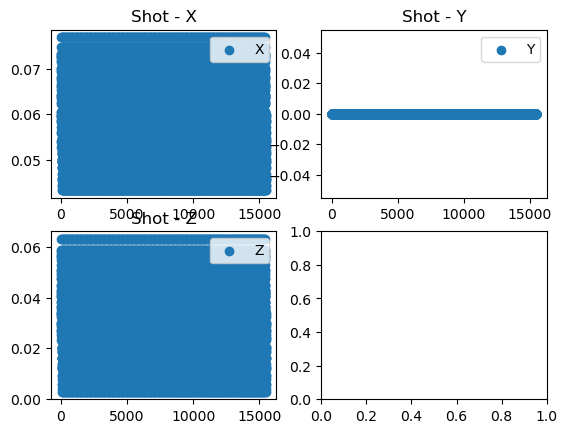

In [ ]:
# For badminton1
bdm1_delta_x, bdm1_delta_y, bdm1_delta_z, bdm2_delta_x, bdm2_delta_y, bdm2_delta_z = [], [], [], [], [], []
# Perform for shot 1
for i in range(1, badminton1.groupby('SHOT_ID').ngroups+1):
    bdm1_x_length = badminton1['X'][62] - badminton1['X'][0]
    bdm1_y_length = badminton1['Y'][62] - badminton1['Y'][0]
    bdm1_z_length = badminton1['Z'][62] - badminton1['Z'][0]
    bdm2_x_length = badminton2['X'][62] - badminton2['X'][0]
    bdm2_y_length = badminton2['Y'][62] - badminton2['Y'][0]
    bdm2_z_length = badminton2['Z'][62] - badminton2['Z'][0]
    for i in range(1, 63):
        bdm1_delta_x.append(badminton1['X'][i+1] - badminton1['X'][i])
        bdm1_delta_y.append(badminton1['Y'][i+1] - badminton1['Y'][i])
        bdm1_delta_z.append(badminton1['Z'][i+1] - badminton1['Z'][i])
        bdm2_delta_x.append(badminton2['X'][i+1] - badminton2['X'][i])
        bdm2_delta_y.append(badminton2['Y'][i+1] - badminton2['Y'][i])
        bdm2_delta_z.append(badminton2['Z'][i+1] - badminton2['Z'][i])
print(len(bdm1_delta_x))
fig, axs = plt.subplots(2,2)
axs[0][0].scatter(range(1, 15501), bdm1_delta_x, label='X')
axs[0][1].scatter(range(1, 15501), bdm1_delta_y, label='Y')
axs[1][0].scatter(range(1, 15501), bdm1_delta_z, label='Z')
# Set legends and titles for each plot
axs[0][0].legend()
axs[0][0].set_title('Shot - X')

axs[0][1].legend()
axs[0][1].set_title('Shot - Y')

axs[1][0].legend()
axs[1][0].set_title('Shot - Z')
print(angle(bdm1_delta_x, bdm1_delta_z))